In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import validate
from openbabel import openbabel, pybel

2023-04-09 12:03:32.124652: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 12:03:33.124166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
our_dccs, our_dvo = validate.validate('../validation_data/scPDB', '../validation_data/output_our')

The output of the previous cell is all the openbabel errors that I have hided for comodity.
Since that step takes a long time, I save the dcc output in a pickle. It's what I need at least.

In [7]:
import pickle
with open('our_model_dccs_dvos.pickle', 'wb') as handle:
    pickle.dump(our_dccs, handle, protocol=pickle.HIGHEST_PROTOCOL)


Now, I define all the functions to generate the final plot. I need tocalculate dcccs for the other methods we want to compare and in that case we cannot use the functions in validate.py that we use for our model, the path strucutre and the files we have is different. Then I need to convert the dict of dccs from the  pickle and the other methods to a proper list of ranked pockets to do the plots.

In [5]:
def get_coords(file_path, file_type):
    atom_coords = []
    residues = []
    with open(file_path, "r") as file:
        
        if file_type == "mol2":
            start = False
            for line in file:
                if "@<TRIPOS>ATOM" in line:
                    start = True
                elif "@<TRIPOS>BOND" in line:
                    start = False
                elif start == True:
                    x = float(line[17:26])
                    y = float(line[27:36])
                    z = float(line[37:46])
                    res = line[64:72].strip()
                    atom_coords.append([x,y,z])
                    residues.append(res)
                    
        elif file_type == "pdb":
            for line in file:
                if line.startswith("ATOM") or line.startswith("HETATM"):
                        x = float(line[31:38])
                        y = float(line[39:46])
                        z = float(line[47:55])

                        res_num = line[23:27]
                        res_name = line[17:20]
                        res = (res_name + res_num).strip()
                        
                        atom_coords.append([x,y,z])
                        residues.append(res)
                
            
    return atom_coords, residues
def read_fpocket(fpocket_folder, scPDB_folder):
    total_val_proteins = 0
    predicted_pockets = 0
    dcc_success = 0
    dvo_vals = []

    dccs = {}
    dvos = {}

    for result in glob.glob(fpocket_folder+'/*_out'):
        pdb_code = result.split('/')[-1]
        pdb_code = '_'.join(pdb_code.split('_')[0:2])
        #print(pdb_code)

        dcc_current = []
        dvo_current = []

        #Fpocket result in result+/+pdb_code_out.pdb or in pockets folder one by one...
            # as result+/+pockets/+pocketXX_atm.pdb
        #original pocket in :
            # scPDB/+pdb_code+/+cavity6.mol2
        
        #real_bs = next(pybel.readfile('mol2', scPDB_folder+'/'+pdb_code+'/cavity6.mol2'))
        real_bs_coords, _ = get_coords(scPDB_folder+'/'+pdb_code+'/cavity6.mol2', 'mol2')
        real_bs_coords = np.array(real_bs_coords)

        for pocket in glob.glob(result+'/pockets/pocket*_vert.pqr'):
            #predicted_bs = next(pybel.readfile('pdb', pocket))
            predicted_bs_coords, _ = get_coords(pocket, 'pdb')
            predicted_bs_coords = np.array(predicted_bs_coords)

            # Calculate DCC:  
            #print(real_bs_coords)
            #print(predicted_bs_coords)
            dcc = np.linalg.norm(real_bs_coords.mean(axis=0) - predicted_bs_coords.mean(axis=0))
            dcc_current.append(dcc)
            if dcc < 4:
                dcc_success += 1
                dvo = validate.calculate_DVO(real_bs_coords, predicted_bs_coords)
                dvo_vals.append(dvo)
                dvo_current.append(dvo)
            if len(dcc_current) > 0:
                dccs[pdb_code] = min(dcc_current)
            if len(dvo_current) > 0:
                dvos[pdb_code] = min(dvo_current)
    return dccs, dvos

def calculate_metrics(dccs_df):
    Success_rate = []
    for index, pocket in dccs_df.iterrows():
        Positives = len(dccs_df['true_val'][0:index])
        Negatives = len(dccs_df['true_val'][index:])
        Success_rate.append(Positives/(Negatives+Positives))
    return Success_rate

Preparing the results from our model (I have already run the first cells in this notebook that runed validate.py.)

In [ ]:
import pickle
with open('our_model_dccs_dvos.pickle', 'rb') as handle:
    our_dccs = pickle.load(handle)
handle.close()
dccs_df = pd.DataFrame.from_dict(our_dccs, orient='index')
dccs_df.sort_values(0, inplace=True)
dccs_df['RANK'] = np.arange(dccs_df.shape[0])
dccs_df['protein'] = dccs_df.index
dccs_df = dccs_df.set_index('RANK', drop=False)

In [70]:
dccs_df

,0,true_val,RANK,protein
RANK,,,,
0,0.138119,1,0,1zdf_1
1,0.233977,1,1,2ga2_1
2,0.265833,1,2,2cx8_2
3,0.315316,1,3,3fri_1
4,0.330047,1,4,4o9k_2
...,...,...,...,...
217,NaN,0,217,2nxe_2
218,NaN,0,218,4uox_2
219,NaN,0,219,4xg1_3


Prepare the results for fpocket

In [48]:
fpocket_dccs, fpocket_dvos = read_fpocket('../validation_data/input_fpocket', '../db/scPDB')

In [49]:
fpocket_dccs_df = pd.DataFrame.from_dict(fpocket_dccs, orient='index')
fpocket_dccs_df = fpocket_dccs_df.assign(true_val=[1 if x < 4 else 0 for x in fpocket_dccs_df[0]])
fpocket_dccs_df.sort_values(0, inplace=True)
fpocket_dccs_df['RANK'] = np.arange(fpocket_dccs_df.shape[0])
fpocket_dccs_df['protein'] = fpocket_dccs_df.index
fpocket_dccs_df = fpocket_dccs_df.set_index('RANK', drop=False)


In [54]:
fpocket_dccs_df

,0,true_val,RANK,protein
RANK,,,,
0,0.195759,1,0,3vpb_4
1,0.250526,1,1,4f3g_1
2,0.257943,1,2,4uy6_1
3,0.260845,1,3,5kbw_1
4,0.276329,1,4,4o9k_2
...,...,...,...,...
264,9.143026,0,264,2gks_1
265,9.706857,0,265,3oz2_1
266,10.028170,0,266,4hne_1


In [62]:
fpocket_Success_rate = calculate_metrics(fpocket_dccs_df)

Prepare the results for puresnet

In [6]:
def read_puresnet(puresnet_folder, scPDB_folder):
    total_val_proteins = 0
    predicted_pockets = 0
    dcc_success = 0
    dvo_vals = []

    dccs = {}
    dvos = {}
    
    for result in glob.glob(puresnet_folder+'/*'):
        pdb_code = result.split('/')[-1]
        pdb_code = pdb_code.split('.')[0]

        dcc_current = []
        dvo_current = []

        #puresnet results are in result+/pocketX.mol2
        #original pocket in :
            # scPDB/+pdb_code+/+cavity6.mol2
        
        #real_bs = next(pybel.readfile('mol2', scPDB_folder+'/'+pdb_code+'/cavity6.mol2'))
        real_bs_coords, _ = get_coords(scPDB_folder+'/'+pdb_code+'/cavity6.mol2', 'mol2')
        real_bs_coords = np.array(real_bs_coords)


        for pocket in glob.glob(result+'/pocket*.mol2'):
            #predicted_bs = next(pybel.readfile('pdb', pocket))
            predicted_bs_coords, _ = get_coords(pocket, 'mol2')
            predicted_bs_coords = np.array(predicted_bs_coords)

            # Calculate DCC:  
            #print(real_bs_coords)
            #print(predicted_bs_coords)
            dcc = np.linalg.norm(real_bs_coords.mean(axis=0) - predicted_bs_coords.mean(axis=0))
            dcc_current.append(dcc)
            if dcc < 4:
                dcc_success += 1
                dvo = validate.calculate_DVO(real_bs_coords, predicted_bs_coords)
                dvo_vals.append(dvo)
                dvo_current.append(dvo)
            if len(dcc_current) > 0:
                dccs[pdb_code] = min(dcc_current)
            if len(dvo_current) > 0:
                dvos[pdb_code] = min(dvo_current)
    return dccs, dvos

In [106]:
puresnet_dccs, puresnet_dvos = read_puresnet('../validation_data/output_puresnet', '../db/scPDB')

puresnet_dccs_df = pd.DataFrame.from_dict(puresnet_dccs, orient='index')
puresnet_dccs_df = puresnet_dccs_df.assign(true_val=[1 if x < 4 else 0 for x in puresnet_dccs_df[0]])
puresnet_dccs_df.sort_values(0, inplace=True)
puresnet_dccs_df['RANK'] = np.arange(puresnet_dccs_df.shape[0])
puresnet_dccs_df['protein'] = puresnet_dccs_df.index
puresnet_dccs_df = puresnet_dccs_df.set_index('RANK', drop=False)

/tmp/ipykernel_25612/1007736694.py:34: RuntimeWarning: Mean of empty slice.
  dcc = np.linalg.norm(real_bs_coords.mean(axis=0) - predicted_bs_coords.mean(axis=0))
/home/marc/anaconda3/envs/SBI_ml/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [107]:
puresnet_dccs_df

,0,true_val,RANK,protein
RANK,,,,
0,0.207843,1,0,1o51_1
1,0.214842,1,1,1v8k_1
2,0.220075,1,2,2afw_1
3,0.286072,1,3,3fri_1
4,0.287385,1,4,1zdf_1
...,...,...,...,...
242,NaN,0,242,4fpy_1
243,NaN,0,243,3r9v_2
244,NaN,0,244,3fqa_1


Plots

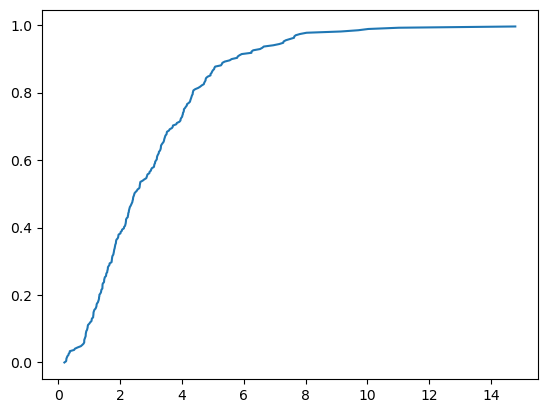

In [64]:
plt.plot(fpocket_dccs_df[0], fpocket_Success_rate)

(0.0, 20.0)

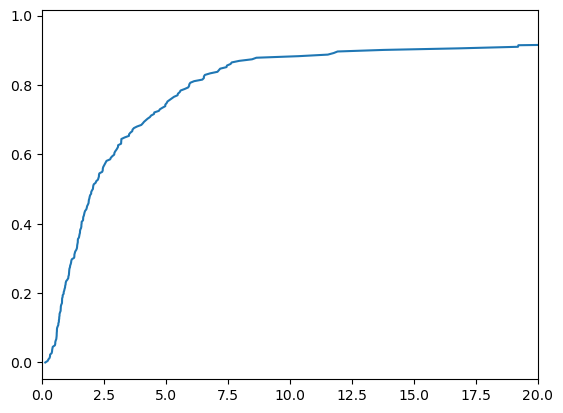

In [67]:
our_success_rate = calculate_metrics(dccs_df)
plt.plot(dccs_df[0], our_success_rate)
plt.xlim([0,20])

(0.0, 20.0)

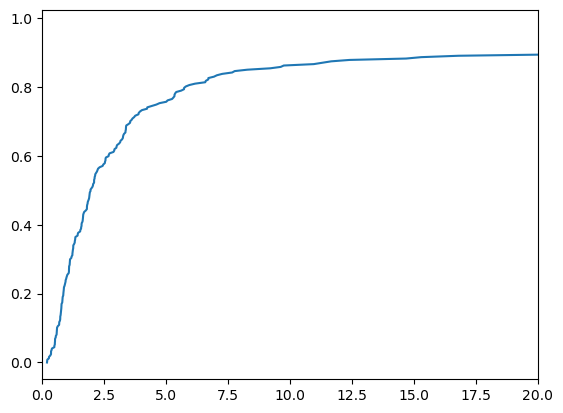

In [108]:
puresnet_success = calculate_metrics(puresnet_dccs_df)
plt.plot(puresnet_dccs_df[0], puresnet_success)
plt.xlim([0,20])

Ploting all three results in the same plot for the paper.

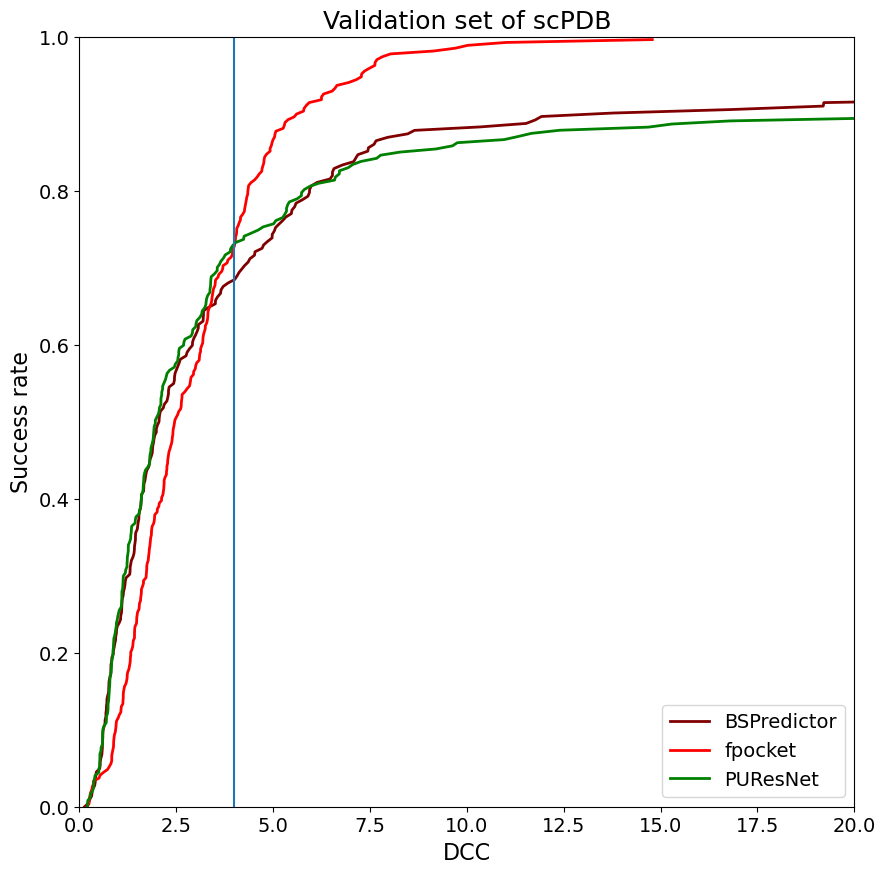

In [110]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(
    dccs_df[0], our_success_rate,
    color="maroon",
    lw=lw,
    label="BSPredictor"
    )
plt.plot(
    fpocket_dccs_df[0], fpocket_Success_rate,
    color="red",
    lw=lw,
    label="fpocket"
    )

plt.plot(puresnet_dccs_df[0], puresnet_success,
         color='green',
         lw=lw,
         label='PUResNet'
         )
#plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.vlines(4, ymin=0, ymax=100)
plt.xlim([0.0, 20])
plt.ylim([0.0, 1.0])
plt.xlabel("DCC", fontsize=16)
plt.ylabel("Success rate", fontsize=16)
plt.title('Validation set of scPDB', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
#plt.savefig('/da.png', dpi=250, format='png')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

### Calculate the succcess rate at given threshold
We define 4A as the threshold to determine that the program has been able toproperly predict that binding site (I'm refering to DCC values) We can use this to calculate a success rate value.

In [77]:
print(len(dccs_df.loc[dccs_df['true_val'] == 1])/len(dccs_df))
print("Our model Success rate")

0.6846846846846847
Our model Success rate


In [80]:
print(len(fpocket_dccs_df.loc[fpocket_dccs_df['true_val'] == 1])/len(fpocket_dccs_df))
print("Fpocket success rate")

0.7286245353159851
Fpocket success rate


In [111]:
print(len(puresnet_dccs_df.loc[puresnet_dccs_df['true_val'] == 1])/len(puresnet_dccs_df))
print("Puresnet success rate")

0.7327935222672065
Puresnet success rate


## Trying to work with other independent sets

Then the real cavities are saved diferently. In fact we do not have the cavities but the ligands.


In [7]:
def coach420_fpocket(fpocket_folder, scPDB_folder):
    total_val_proteins = 0
    predicted_pockets = 0
    dcc_success = 0
    dvo_vals = []

    dccs = {}
    dvos = {}

    for result in glob.glob(fpocket_folder+'/*_out'):
        pdb_code = result.split('/')[-1]
        pdb_code = pdb_code.split('_')[0]
        #print(pdb_code)

        dcc_current = []
        dvo_current = []

        #Fpocket result in result+/+pdb_code_out.pdb or in pockets folder one by one...
            # as result+/+pockets/+pocketXX_atm.pdb
        #original pocket in :
            # scPDB/+pdb_code+/+cavity6.mol2
        
        #real_bs = next(pybel.readfile('mol2', scPDB_folder+'/'+pdb_code+'/cavity6.mol2'))
        real_bs_coords, _ = get_coords(scPDB_folder+'/'+pdb_code+'/ligand.pdb', 'pdb')
        real_bs_coords = np.array(real_bs_coords)

        for pocket in glob.glob(result+'/pockets/pocket*_vert.pqr'):
            #predicted_bs = next(pybel.readfile('pdb', pocket))
            predicted_bs_coords, _ = get_coords(pocket, 'pdb')
            predicted_bs_coords = np.array(predicted_bs_coords)

            # Calculate DCC:  
            #print(real_bs_coords)
            #print(predicted_bs_coords)
            dcc = np.linalg.norm(real_bs_coords.mean(axis=0) - predicted_bs_coords.mean(axis=0))
            dcc_current.append(dcc)
            if dcc < 4:
                dcc_success += 1
                dvo = validate.calculate_DVO(real_bs_coords, predicted_bs_coords)
                dvo_vals.append(dvo)
                dvo_current.append(dvo)
            if len(dcc_current) > 0:
                dccs[pdb_code] = min(dcc_current)
            if len(dvo_current) > 0:
                dvos[pdb_code] = min(dvo_current)
    return dccs, dvos

def coach420_puresnet(puresnet_folder, scPDB_folder):
    total_val_proteins = 0
    predicted_pockets = 0
    dcc_success = 0
    dvo_vals = []

    dccs = {}
    dvos = {}
    
    for result in glob.glob(puresnet_folder+'/*'):
        pdb_code = result.split('/')[-1]
        pdb_code = pdb_code.split('.')[0]

        dcc_current = []
        dvo_current = []

        #puresnet results are in result+/pocketX.mol2
        #original pocket in :
            # scPDB/+pdb_code+/+cavity6.mol2
        
        #real_bs = next(pybel.readfile('mol2', scPDB_folder+'/'+pdb_code+'/cavity6.mol2'))
        real_bs_coords, _ = get_coords(scPDB_folder+'/'+pdb_code+'/ligand.pdb', 'pdb')
        real_bs_coords = np.array(real_bs_coords)


        for pocket in glob.glob(result+'/pocket*.mol2'):
            #predicted_bs = next(pybel.readfile('pdb', pocket))
            predicted_bs_coords, _ = get_coords(pocket, 'mol2')
            predicted_bs_coords = np.array(predicted_bs_coords)

            # Calculate DCC:  
            #print(real_bs_coords)
            #print(predicted_bs_coords)
            dcc = np.linalg.norm(real_bs_coords.mean(axis=0) - predicted_bs_coords.mean(axis=0))
            dcc_current.append(dcc)
            if dcc < 4:
                dcc_success += 1
                dvo = validate.calculate_DVO(real_bs_coords, predicted_bs_coords)
                dvo_vals.append(dvo)
                dvo_current.append(dvo)
            if len(dcc_current) > 0:
                dccs[pdb_code] = min(dcc_current)
            if len(dvo_current) > 0:
                dvos[pdb_code] = min(dvo_current)
    return dccs, dvos

In [8]:
fpocket_coach420_dccs, fpocket_coach420_dvos = coach420_fpocket('../validation_data/coach420_fpocket', '../db/coach/coach420')


In [9]:
puresnet_coach420_dccs, puresnet_coach420_dvos = coach420_puresnet('../validation_data/coach420_puresnet_output', '../db/coach/coach420')

/tmp/ipykernel_6982/2967153505.py:81: RuntimeWarning: Mean of empty slice.
  dcc = np.linalg.norm(real_bs_coords.mean(axis=0) - predicted_bs_coords.mean(axis=0))
/home/marc/anaconda3/envs/SBI_ml/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
our_coach420_dccs, our_coach420_dvos = coach420_puresnet('../validation_data/coach420_our_output', '../db/coach/coach420')

/tmp/ipykernel_6982/2967153505.py:81: RuntimeWarning: Mean of empty slice.
  dcc = np.linalg.norm(real_bs_coords.mean(axis=0) - predicted_bs_coords.mean(axis=0))


In [11]:
def get_success(puresnet_dccs):
    puresnet_dccs_df = pd.DataFrame.from_dict(puresnet_dccs, orient='index')
    puresnet_dccs_df = puresnet_dccs_df.assign(true_val=[1 if x < 4 else 0 for x in puresnet_dccs_df[0]])
    puresnet_dccs_df.sort_values(0, inplace=True)
    puresnet_dccs_df['RANK'] = np.arange(puresnet_dccs_df.shape[0])
    puresnet_dccs_df['protein'] = puresnet_dccs_df.index
    puresnet_dccs_df = puresnet_dccs_df.set_index('RANK', drop=False)
    puresnet_Success_rate = calculate_metrics(puresnet_dccs_df)
    return puresnet_Success_rate, puresnet_dccs_df

In [12]:
fpocket_coach420_success, fpocket_coach420_dccs_df = get_success(fpocket_coach420_dccs)
puresnet_coach420_success, puresnet_coach420_dccs_df = get_success(puresnet_coach420_dccs)
our_coach420_success, our_coach420_dccs_df = get_success(our_coach420_dccs)


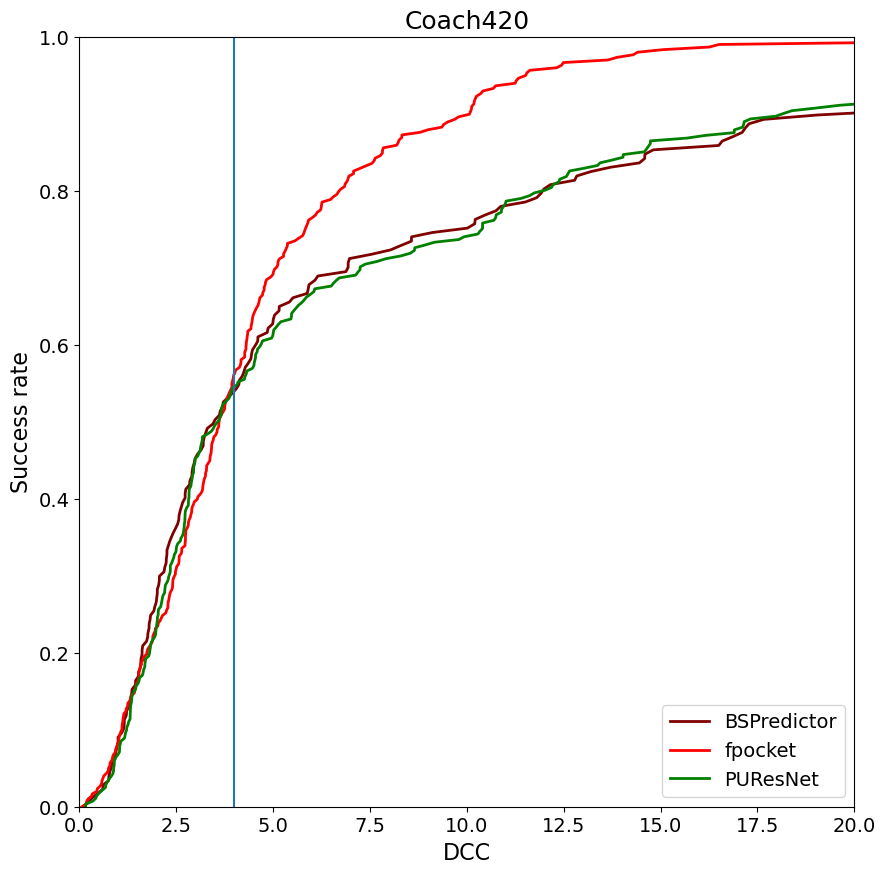

In [16]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(
    our_coach420_dccs_df[0], our_coach420_success,
    color="maroon",
    lw=lw,
    label="BSPredictor"
    )
plt.plot(
    fpocket_coach420_dccs_df[0], fpocket_coach420_success,
    color="red",
    lw=lw,
    label="fpocket"
    )

plt.plot(puresnet_coach420_dccs_df[0], puresnet_coach420_success,
         color='green',
         lw=lw,
         label='PUResNet'
         )
#plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.vlines(4, ymin=0, ymax=100)
plt.xlim([0.0, 20])
plt.ylim([0.0, 1.0])
plt.xlabel("DCC", fontsize=16)
plt.ylabel("Success rate", fontsize=16)
plt.title('Coach420', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('coach420.png', dpi=250, format='png')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()